In [2]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [3]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import tensorflow
tf_logger = tensorflow.get_logger()
tf_logger.setLevel("ERROR")

# How to classify new sequences?

This notebook contains a tutorial that shows you how to classify new sequences. 

The work started as an alternative interface from L. Hoebeke: relying on the camtrap data standard, uses a more recent Python/keras version and using a more object oriented code structure. Doing so, the code structure has been altered to provide a more general interface to classify cameratrap images which supports the implementation by L.Hoebeke, but also enables to use alternative models for object detection and animal classification. 

The L. Hoebeke implementation tries to mimic the concepts and original implementation of the algorithms and models by L.Hoebeke as close as possible. 

## Input data

When running an existing model on a set of images, the required data are:

* Camera trap images, in subfolders per deployment 
* [camtrap-dp](https://gitlab.com/oscf/camtrap-dp/-/tree/development) data package. For predictions, only the `multimedia.csv` data is required, containing the references to the images captured by the camera traps associated with deployments (`deployment_id`) and organized in sequences (`sequence_id`)

We assume the following main directory structure for the raw data:

```
data/raw/
├── 05c05f7b-6c38-4a06-a3b0-145de226c8ad
│   ├── ...
│   └── 20200510175524-RCNX0940.JPG
├── 18ba7237-4b3f-4a5d-83d0-8c10e604aed4
│   └── ...
├── ...
├── 9d2d2d81-e5dc-4841-ad75-162f79991c31
│   └── ...
├── datapackage.json
├── deployments.csv
├── multimedia.csv
└── observations.csv
```

(_No worries if the data is not yet available locally, as this can be downloaded using the code directly, see further_)

With the _hash_-based directories (e.g. `05c05f7b-6c38-4a06-a3b0-145de226c8ad`) the individual deployments of interest containing the cameratrap images of the deployment. The remaining files are the extracted camtrap-dp data package files.

For this tutorial, we have the data in a folder `data/raw/` in the same folder as the `notebooks` folder, which we can define relative. Using Pandas package to read in the multimedia file:

In [5]:
multimedia = pd.read_csv("../data/raw/multimedia.csv", low_memory=False)
multimedia

,multimedia_id,deployment_id,sequence_id,timestamp,file_path,file_name,file_mediatype,comments
0,321e41a0-2011-459f-b99e-6ce200b00908,005eaf17-3197-425a-b607-f831d458e2d7,e0b65f26-f9db-414c-a890-f8c6f3f5808e,2020-10-08T09:51:23Z,https://www.agouti.eu/api/uploads/deployment-i...,20201112103814-RCNX0001.JPG,image/jpeg,NaN
1,dbf8e774-d7c7-416d-b878-0baa880126c6,005eaf17-3197-425a-b607-f831d458e2d7,e0b65f26-f9db-414c-a890-f8c6f3f5808e,2020-10-08T09:51:24Z,https://www.agouti.eu/api/uploads/deployment-i...,20201112103814-RCNX0002.JPG,image/jpeg,NaN
2,54eccb67-f2f3-4531-b1e9-3bf6f689e2f3,005eaf17-3197-425a-b607-f831d458e2d7,e0b65f26-f9db-414c-a890-f8c6f3f5808e,2020-10-08T09:51:25Z,https://www.agouti.eu/api/uploads/deployment-i...,20201112103814-RCNX0003.JPG,image/jpeg,NaN
3,b3e8bf65-7c5f-4be0-b66f-4dfb81a97762,005eaf17-3197-425a-b607-f831d458e2d7,e0b65f26-f9db-414c-a890-f8c6f3f5808e,2020-10-08T09:51:25Z,https://www.agouti.eu/api/uploads/deployment-i...,20201112103814-RCNX0004.JPG,image/jpeg,NaN
4,6fdf1f1a-8cd6-4a51-bbb3-244416e4c012,005eaf17-3197-425a-b607-f831d458e2d7,e0b65f26-f9db-414c-a890-f8c6f3f5808e,2020-10-08T09:51:26Z,https://www.agouti.eu/api/uploads/deployment-i...,20201112103814-RCNX0005.JPG,image/jpeg,NaN
...,...,...,...,...,...,...,...,...
717233,d565898b-3349-41cf-b3ce-e0b28b4eb00e,fff2f46e-8163-453c-9044-61fb77587f5d,f44f9cda-c2cf-4f51-a2d1-45d22983729a,2020-06-08T02:14:22Z,https://www.agouti.eu/api/uploads/deployment-i...,20200708153604-RCNX6489.JPG,image/jpeg,NaN
717234,04538c5c-2a21-49da-bde4-cdab47c29ce4,fff2f46e-8163-453c-9044-61fb77587f5d,f44f9cda-c2cf-4f51-a2d1-45d22983729a,2020-06-08T02:14:23Z,https://www.agouti.eu/api/uploads/deployment-i...,20200708153604-RCNX6490.JPG,image/jpeg,NaN
717235,fdde8639-6ba6-4817-bdf8-4e04b96784c3,fff2f46e-8163-453c-9044-61fb77587f5d,f44f9cda-c2cf-4f51-a2d1-45d22983729a,2020-06-08T02:14:38Z,https://www.agouti.eu/api/uploads/deployment-i...,20200708153604-RCNX6491.JPG,image/jpeg,NaN
717236,843ce0e5-1ec3-47e5-b352-d011d67f21e6,fff2f46e-8163-453c-9044-61fb77587f5d,f44f9cda-c2cf-4f51-a2d1-45d22983729a,2020-06-08T02:14:40Z,https://www.agouti.eu/api/uploads/deployment-i...,20200708153604-RCNX6492.JPG,image/jpeg,NaN


In [6]:
import numpy as np
sequences = multimedia["sequence_id"].unique().copy()
np.random.shuffle(sequences)

Pandas provides the required functionalities to extract a given deployment or sequence using respectively the `deployment_id` or `sequence_id`. For example:

In [7]:
# subselect a deployment
multimedia[multimedia["deployment_id"] == "0633fab2-bbee-4346-8b39-a28345e1f052"].head()

,multimedia_id,deployment_id,sequence_id,timestamp,file_path,file_name,file_mediatype,comments
19363,d24bf9b6-bc46-4ca4-8a8e-8a8a7661d78c,0633fab2-bbee-4346-8b39-a28345e1f052,a3032f2c-4c63-4b50-b4e7-75e7c2cd1fcd,2020-09-13T01:25:48Z,https://www.agouti.eu/api/uploads/deployment-i...,20201002112850-RCNX0001.JPG,image/jpeg,NaN
19364,5c05d3b4-3c1b-468e-b56b-c8514814e24a,0633fab2-bbee-4346-8b39-a28345e1f052,a3032f2c-4c63-4b50-b4e7-75e7c2cd1fcd,2020-09-13T01:26:33Z,https://www.agouti.eu/api/uploads/deployment-i...,20201002112851-RCNX0002.JPG,image/jpeg,NaN
19365,9e3d4fe2-7d28-4eaf-b690-bad672dad163,0633fab2-bbee-4346-8b39-a28345e1f052,a3032f2c-4c63-4b50-b4e7-75e7c2cd1fcd,2020-09-13T01:26:34Z,https://www.agouti.eu/api/uploads/deployment-i...,20201002112851-RCNX0003.JPG,image/jpeg,NaN
19366,d9c89b28-1813-4dbf-92cc-6aa34588d6bf,0633fab2-bbee-4346-8b39-a28345e1f052,a3032f2c-4c63-4b50-b4e7-75e7c2cd1fcd,2020-09-13T01:26:34Z,https://www.agouti.eu/api/uploads/deployment-i...,20201002112851-RCNX0004.JPG,image/jpeg,NaN
19367,c727a630-e0a1-4ca8-820e-1a6a508375d0,0633fab2-bbee-4346-8b39-a28345e1f052,a3032f2c-4c63-4b50-b4e7-75e7c2cd1fcd,2020-09-13T01:26:35Z,https://www.agouti.eu/api/uploads/deployment-i...,20201002112851-RCNX0005.JPG,image/jpeg,NaN


In [8]:
# subselect a sequence
multimedia[multimedia["sequence_id"] == "8271d989-5f1d-4ac7-858b-c8384c81cd35"].head()

,multimedia_id,deployment_id,sequence_id,timestamp,file_path,file_name,file_mediatype,comments
495395,d4c78d26-b4a7-4ef7-9dbd-c67901b39444,9d2d2d81-e5dc-4841-ad75-162f79991c31,8271d989-5f1d-4ac7-858b-c8384c81cd35,2020-04-29T03:08:34Z,https://www.agouti.eu/api/uploads/deployment-i...,20200605064627-RCNX0181.JPG,image/jpeg,NaN
495396,e09790f5-e876-4013-b824-a67ca69d67e9,9d2d2d81-e5dc-4841-ad75-162f79991c31,8271d989-5f1d-4ac7-858b-c8384c81cd35,2020-04-29T03:08:36Z,https://www.agouti.eu/api/uploads/deployment-i...,20200605064628-RCNX0182.JPG,image/jpeg,NaN
495397,6613e69a-ee7a-4d28-8059-9f4561ae572f,9d2d2d81-e5dc-4841-ad75-162f79991c31,8271d989-5f1d-4ac7-858b-c8384c81cd35,2020-04-29T03:08:37Z,https://www.agouti.eu/api/uploads/deployment-i...,20200605064628-RCNX0183.JPG,image/jpeg,NaN
495398,2acd6fa0-63ac-4673-85ae-f754b3cfb515,9d2d2d81-e5dc-4841-ad75-162f79991c31,8271d989-5f1d-4ac7-858b-c8384c81cd35,2020-04-29T03:08:37Z,https://www.agouti.eu/api/uploads/deployment-i...,20200605064628-RCNX0184.JPG,image/jpeg,NaN
495399,14b1ce26-8954-4152-9914-93e9315cdfde,9d2d2d81-e5dc-4841-ad75-162f79991c31,8271d989-5f1d-4ac7-858b-c8384c81cd35,2020-04-29T03:08:38Z,https://www.agouti.eu/api/uploads/deployment-i...,20200605064628-RCNX0185.JPG,image/jpeg,NaN


We define the main data folder here, so we can reuse it in the remaining of the tutorial:

In [9]:
MAIN_DATA_PATH = Path("../data/raw")

## camtrap Python interface

To link the model development and preprocessing of L. Hoebeke with the camtrap standard, a small interface is created, which provides two main classes:

- `CameraTrapImage`: Represents an individual image of the multimedia table of camtrap-db, extended with a `local_file_path` to make the link to the locally stored images. Each image has an `multimedia_id` in the table to represent the entity.
- `CameraTrapSequence`: Represents a sequence of `CameraTrapImage` images and is the main level on which the model prediction methods of L. Hoebeke are defined.

Import them from the `cameratrap` package:

In [10]:
from cameratrap import CameraTrapImage, CameraTrapSequence

### `CameraTrapImage`

To load a given image, using the `multimedia_id`, e.g. "b29d609f-8311-44a7-b61a-763a89ee094b", we can define a `CameraTrapImage` from the corresponding id

In [11]:
multimedia_id = "b29d609f-8311-44a7-b61a-763a89ee094b"
my_image = CameraTrapImage.from_multimedia(multimedia, multimedia_id, MAIN_DATA_PATH)
my_image

CameraTrapImage(multimedia_id='b29d609f-8311-44a7-b61a-763a89ee094b', deployment_id='05c05f7b-6c38-4a06-a3b0-145de226c8ad', sequence_id='42fd3501-0677-4eca-a954-ba053f8665c7', timestamp=Timestamp('2019-11-22 12:47:30+0000', tz='UTC'), file_path='https://www.agouti.eu/api/uploads/deployment-images/20191001132016-untitled/05c05f7b-6c38-4a06-a3b0-145de226c8ad/20200211215750-RCNX0051.JPG', file_name='20200211215750-RCNX0051.JPG', file_mediatype='image/jpeg', comments=nan, local_data_path=PosixPath('../data/raw'), local_file_path=PosixPath('../data/raw/05c05f7b-6c38-4a06-a3b0-145de226c8ad/20200211215750-RCNX0051.JPG'), _color_type='color')

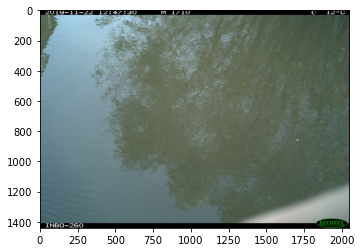

In [12]:
my_image.plot()

The Cameratrap image `my_image` provides a number of methods to work with the data, for example a `plot` method:

In [13]:
my_image.resize(ratio=0.2)

In [14]:
type(my_image.data)

numpy.ndarray

Other relevant methods defined on the image level are `crop` and `resize`, which updates the image data itself:

In [15]:
print(f"Before resize, the image is {my_image.data.shape} pixels.")
my_image.resize(ratio=0.5)
print(f"After resize, the image is {my_image.data.shape} pixels.")
my_image.resize(ratio=0.5)
print(f"After resize a second time, the image is {my_image.data.shape} pixels.")

Before resize, the image is (288, 409, 3) pixels.
After resize, the image is (144, 204, 3) pixels.
After resize a second time, the image is (72, 102, 3) pixels.


Apart of these methodes, the attributes are accessible as well to get more information on the camera trap image, for example the identifiers:

In [16]:
my_image.timestamp, my_image.deployment_id, my_image.multimedia_id, my_image.sequence_id

(Timestamp('2019-11-22 12:47:30+0000', tz='UTC'),
 '05c05f7b-6c38-4a06-a3b0-145de226c8ad',
 'b29d609f-8311-44a7-b61a-763a89ee094b',
 '42fd3501-0677-4eca-a954-ba053f8665c7')

Also the references to the local and remote file link are available:

In [17]:
my_image.file_path, my_image.local_file_path

('https://www.agouti.eu/api/uploads/deployment-images/20191001132016-untitled/05c05f7b-6c38-4a06-a3b0-145de226c8ad/20200211215750-RCNX0051.JPG',
 PosixPath('../data/raw/05c05f7b-6c38-4a06-a3b0-145de226c8ad/20200211215750-RCNX0051.JPG'))

If an image is not yet available the first time the Image is loaded, a download is attempted and the image is stored in the deployment directory:

In [18]:
multimedia_id = "5c05d3b4-3c1b-468e-b56b-c8514814e24a"

In [19]:
other_image = CameraTrapImage.from_multimedia(multimedia, multimedia_id, MAIN_DATA_PATH)
other_image

CameraTrapImage(multimedia_id='5c05d3b4-3c1b-468e-b56b-c8514814e24a', deployment_id='0633fab2-bbee-4346-8b39-a28345e1f052', sequence_id='a3032f2c-4c63-4b50-b4e7-75e7c2cd1fcd', timestamp=Timestamp('2020-09-13 01:26:33+0000', tz='UTC'), file_path='https://www.agouti.eu/api/uploads/deployment-images/20191001132016-untitled/0633fab2-bbee-4346-8b39-a28345e1f052/20201002112851-RCNX0002.JPG', file_name='20201002112851-RCNX0002.JPG', file_mediatype='image/jpeg', comments=nan, local_data_path=PosixPath('../data/raw'), local_file_path=PosixPath('../data/raw/0633fab2-bbee-4346-8b39-a28345e1f052/20201002112851-RCNX0002.JPG'), _color_type='grey')

> In case you did not have this image available already, you will see the following message as part of the output:
>```
>../data/raw/0633fab2-bbee-4346-8b39-a28345e1f052/20201002112851-RCNX0002.JPG does not exist yet, downloading...
>...download ../data/raw/0633fab2-bbee-4346-8b39-a28345e1f052/20201002112851-RCNX0002.JPG succesful.
>```

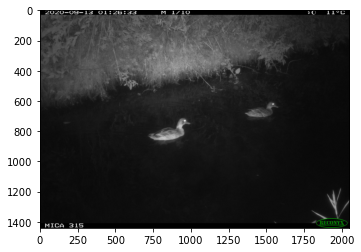

In [20]:
other_image.plot()

__Note__: The data itself is stored as an Numpy array as the `data` attribute of the class for access to the numerical values:

In [21]:
type(other_image.data)

numpy.ndarray

For Matplotlib users, the plot function can be provided by an `axes` object to integrate in a Matplotlib setup, for example:

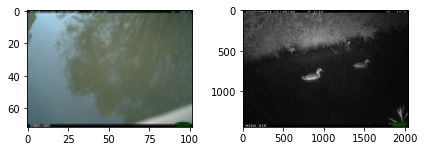

In [22]:
fig, (ax0, ax1) = plt.subplots(1, 2)
my_image.plot(ax=ax0)
other_image.plot(ax=ax1)
plt.tight_layout()

### `CameraTrapSequence`

As the predictions are managed on the Sequence level, the `CameraTrapSequence` provides a direct interface towards the set of images of a Sequence, represented by the `sequence_id`. Loading in a sequence is supported by the `from_multimedia` method:

In [23]:
multimedia

,multimedia_id,deployment_id,sequence_id,timestamp,file_path,file_name,file_mediatype,comments
0,321e41a0-2011-459f-b99e-6ce200b00908,005eaf17-3197-425a-b607-f831d458e2d7,e0b65f26-f9db-414c-a890-f8c6f3f5808e,2020-10-08T09:51:23Z,https://www.agouti.eu/api/uploads/deployment-i...,20201112103814-RCNX0001.JPG,image/jpeg,NaN
1,dbf8e774-d7c7-416d-b878-0baa880126c6,005eaf17-3197-425a-b607-f831d458e2d7,e0b65f26-f9db-414c-a890-f8c6f3f5808e,2020-10-08T09:51:24Z,https://www.agouti.eu/api/uploads/deployment-i...,20201112103814-RCNX0002.JPG,image/jpeg,NaN
2,54eccb67-f2f3-4531-b1e9-3bf6f689e2f3,005eaf17-3197-425a-b607-f831d458e2d7,e0b65f26-f9db-414c-a890-f8c6f3f5808e,2020-10-08T09:51:25Z,https://www.agouti.eu/api/uploads/deployment-i...,20201112103814-RCNX0003.JPG,image/jpeg,NaN
3,b3e8bf65-7c5f-4be0-b66f-4dfb81a97762,005eaf17-3197-425a-b607-f831d458e2d7,e0b65f26-f9db-414c-a890-f8c6f3f5808e,2020-10-08T09:51:25Z,https://www.agouti.eu/api/uploads/deployment-i...,20201112103814-RCNX0004.JPG,image/jpeg,NaN
4,6fdf1f1a-8cd6-4a51-bbb3-244416e4c012,005eaf17-3197-425a-b607-f831d458e2d7,e0b65f26-f9db-414c-a890-f8c6f3f5808e,2020-10-08T09:51:26Z,https://www.agouti.eu/api/uploads/deployment-i...,20201112103814-RCNX0005.JPG,image/jpeg,NaN
...,...,...,...,...,...,...,...,...
717233,d565898b-3349-41cf-b3ce-e0b28b4eb00e,fff2f46e-8163-453c-9044-61fb77587f5d,f44f9cda-c2cf-4f51-a2d1-45d22983729a,2020-06-08T02:14:22Z,https://www.agouti.eu/api/uploads/deployment-i...,20200708153604-RCNX6489.JPG,image/jpeg,NaN
717234,04538c5c-2a21-49da-bde4-cdab47c29ce4,fff2f46e-8163-453c-9044-61fb77587f5d,f44f9cda-c2cf-4f51-a2d1-45d22983729a,2020-06-08T02:14:23Z,https://www.agouti.eu/api/uploads/deployment-i...,20200708153604-RCNX6490.JPG,image/jpeg,NaN
717235,fdde8639-6ba6-4817-bdf8-4e04b96784c3,fff2f46e-8163-453c-9044-61fb77587f5d,f44f9cda-c2cf-4f51-a2d1-45d22983729a,2020-06-08T02:14:38Z,https://www.agouti.eu/api/uploads/deployment-i...,20200708153604-RCNX6491.JPG,image/jpeg,NaN
717236,843ce0e5-1ec3-47e5-b352-d011d67f21e6,fff2f46e-8163-453c-9044-61fb77587f5d,f44f9cda-c2cf-4f51-a2d1-45d22983729a,2020-06-08T02:14:40Z,https://www.agouti.eu/api/uploads/deployment-i...,20200708153604-RCNX6492.JPG,image/jpeg,NaN


In [24]:
sequence_id = 'a3032f2c-4c63-4b50-b4e7-75e7c2cd1fcd'
sequence_grey = CameraTrapSequence.from_multimedia(multimedia, 
                                                   sequence_id,
                                                  Path("../data/raw"))

In [25]:
sequence_grey

CameraTrapSequence(deployment_id='0633fab2-bbee-4346-8b39-a28345e1f052', sequence_id='a3032f2c-4c63-4b50-b4e7-75e7c2cd1fcd', local_data_path=PosixPath('../data/raw'), _color_type='grey')

__Note:__ When not yet available, the images of the sequence will be downloaded first and placed in the deployment directory.

One can access each of the images using the slicing brackets `[]` and the index (starting at zero!):

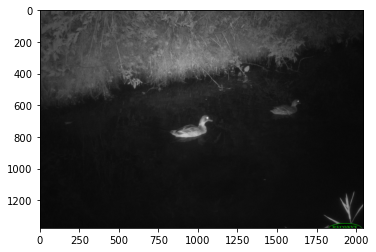

In [26]:
sequence_grey[2].plot()  # try out different indices

__Note__ The removal of the black border of the reconyx images is done on initial load of the image data.

The output of a selection is a `CameraTrapImage` (see previous section):

In [27]:
type(sequence_grey[0])

cameratrap.camtrap.CameraTrapImage

Again, a number of attributes/properties are available to check the information on the sequence, e.g.

In [28]:
sequence_grey.deployment_id, sequence_grey.sequence_id, sequence_grey.color_type

('0633fab2-bbee-4346-8b39-a28345e1f052',
 'a3032f2c-4c63-4b50-b4e7-75e7c2cd1fcd',
 'grey')

Again, a number of methods are available on sequence level, with the most important the `predict` method, applying the prediction methodology of L. Hoebeke and returning the different levels of the hierarchical prediction for the sequence working with:

In [29]:
sequence_grey.resize(ratio=0.5)  # Resize images (as advised by L. Hoebeke)

### Detection algorithms

Before animal classification, extracting the animals from the images can be applied as a preprocessing step. The implementation provides the option to switch the algorithm, with currently the following 2 provided:

- L. Hoebeke (Msc thesis)
- MegaDetector (Microsoft, https://github.com/microsoft/CameraTraps/blob/master/megadetector.md#megadetector-overview)

In [98]:
from cameratrap.camtrap import DetectionHoebeke, DetectionMegaDetector, DetectionDeactive

Use the Hoebeke implementation:

In [31]:
bboxes_hoebeke = sequence_grey.detect(DetectionHoebeke)

Use the Megadetector implementation:

__Note__ The [MegaDetector](https://github.com/microsoft/CameraTraps/blob/master/megadetector.md#downloading-the-model) model is used to detect regions of interest (bounding boxes). The model file is too large to be included in the repository, so make sure to [download the model](https://lilablobssc.blob.core.windows.net/models/camera_traps/megadetector/md_v4.1.0/md_v4.1.0.pb) first and put it in the `weights` subfolder, i.e. `cameratrap/weights/md_v4.1.0.pb`.

In [32]:
bboxes = sequence_grey.detect(DetectionMegaDetector)

TFDetector: Loading graph...
TFDetector: Detection graph loaded.


The output of both is different. For night images with lots of water, both do have difficulties in extracting the animals:

In [33]:
sequence_grey.draw_regions_of_interest(bboxes, file_path='../data/interim/draw')

In some situations, one might just want to return the image dimensions itself to use as a region of interest. A dedicated ``DetectionDeactive`` is provided just for this:

In [115]:
bboxes_dummy = sequence_grey.detect(DetectionDeactive)
bboxes_dummy

[(0, 0, 1023, 687),
 (0, 0, 1023, 687),
 (0, 0, 1023, 687),
 (0, 0, 1023, 687),
 (0, 0, 1023, 687),
 (0, 0, 1023, 687),
 (0, 0, 1023, 687),
 (0, 0, 1023, 687),
 (0, 0, 1023, 687),
 (0, 0, 1023, 687),
 (0, 0, 1023, 687)]

### Classification models

Also for the classification/prediction of the labels, implementatations can be interchanged by using or creating a subclass of the `BaseClassification` class:

In [34]:
from cameratrap.camtrap import ClassificationTensorflow, ClassificationHoebeke

Using a __Tensorflow pretrained__ model:

__NOTE__ Before running the code, make sure to download the [inaturalist species trained model, faster_rcnn_resnet101_fgvc](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md#inaturalist-species-trained-models), extract it and save it into the weights folder. The model directory should be `cameratrap/weights/faster_rcnn_resnet101_fgvc_2018_07_19/saved_model`: 

In [35]:
model_path = "../cameratrap/weights/faster_rcnn_resnet101_fgvc_2018_07_19/saved_model/"
predictions = sequence_grey.predict(ClassificationTensorflow, bboxes, model_path)

In [36]:
predictions

[{'detection_classes': array([1693, 1693, 2304, 2304, 1693]),
  'detection_scores': array([0.00024477, 0.00023953, 0.00022165, 0.00018187, 0.00014125],
        dtype=float32),
  'detection_boxes': array([[0.5754087 , 0.        , 0.9990247 , 0.9646639 ],
         [0.74225086, 0.        , 0.99479103, 0.8515177 ],
         [0.5964583 , 0.        , 0.94347584, 0.8914372 ],
         [0.4723094 , 0.        , 0.93427724, 0.5955886 ],
         [0.6090499 , 0.        , 0.99411446, 0.45543915]], dtype=float32),
  'num_detections': 5},
 {'detection_classes': array([2414,  160,  221, 2472, 1018]),
  'detection_scores': array([0.42256385, 0.16891794, 0.09379116, 0.07950386, 0.0616278 ],
        dtype=float32),
  'detection_boxes': array([[0.07503044, 0.10661018, 0.94656247, 0.97498393],
         [0.03894258, 0.08466545, 0.83778536, 0.9766338 ],
         [0.        , 0.28711155, 0.9976565 , 0.951403  ],
         [0.1348994 , 0.08962885, 0.95565784, 0.9388794 ],
         [0.17026635, 0.07021967, 0.91

([[[870, 239, 929, 305]],
  [[356, 338, 502, 423], [674, 284, 789, 346]],
  [[386, 329, 548, 420], [723, 279, 829, 339]],
  [[459, 320, 598, 410], [769, 273, 870, 331]],
  [[511, 310, 646, 399], [812, 266, 908, 327]],
  [[554, 302, 694, 386], [858, 258, 947, 312]],
  [[609, 295, 742, 376], [901, 250, 980, 307], [555, 297, 741, 395]],
  [[678, 284, 789, 365], [938, 242, 1013, 300]],
  [[730, 276, 836, 353], [967, 237, 1023, 285]],
  [[778, 267, 878, 339]],
  [[814, 259, 914, 328]]],
 <matplotlib.image.AxesImage at 0x7f504852da30>)

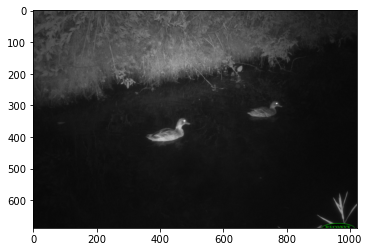

In [37]:
bboxes, sequence_grey[1].plot()

The model returns the class identifiers, which need to be translated to labels. For the example model, the labels are available on Github:

In [39]:
labels = pd.read_csv("https://raw.githubusercontent.com/tensorflow/datasets/master/tensorflow_datasets/image_classification/inaturalist_labels.txt", 
                     header=None, names=["labels"]).to_dict()["labels"]

The output is the same, but `detection_classes_names` are added to the different predictions:

In [118]:
predictions = sequence_grey.predict(ClassificationTensorflow, bboxes, model_path, class_labels=labels)

In [119]:
predictions

[{'detection_boxes': array([[0.5754087 , 0.        , 0.9990247 , 0.9646639 ],
         [0.74225086, 0.        , 0.99479103, 0.8515177 ],
         [0.5964583 , 0.        , 0.94347584, 0.8914372 ],
         [0.4723094 , 0.        , 0.93427724, 0.5955886 ],
         [0.6090499 , 0.        , 0.99411446, 0.45543915]], dtype=float32),
  'detection_classes': array([1693, 1693, 2304, 2304, 1693]),
  'detection_scores': array([0.00024477, 0.00023953, 0.00022165, 0.00018187, 0.00014125],
        dtype=float32),
  'num_detections': 5,
  'detection_classes_names': ['Arundina graminifolia',
   'Arundina graminifolia',
   'Trichodes ornatus',
   'Trichodes ornatus',
   'Arundina graminifolia']},
 {'detection_boxes': array([[0.07503044, 0.10661018, 0.94656247, 0.97498393],
         [0.03894258, 0.08466545, 0.83778536, 0.9766338 ],
         [0.        , 0.28711155, 0.9976565 , 0.951403  ],
         [0.1348994 , 0.08962885, 0.95565784, 0.9388794 ],
         [0.17026635, 0.07021967, 0.91411   , 0.904002

Using __L. Hoebeke__ model for the Hoebeke classification:

In [41]:
sequence_grey.predict(ClassificationHoebeke, bboxes_hoebeke, "../cameratrap/weights/")

,level_1,level_1_p,level_2,level_2_p,level_3,level_3_p,level_4,level_4_p,level_5,level_5_p,final_prediction
0,not_blank,1.0,no_animal,0.909091,pickup,0.909091,NaN,NaN,NaN,NaN,PickupSetup


To define a new subclass, Inherit BaseClassification and overwrite the predict method which needs a `sequence` and a `box_list` as input.

### Prediction step-by-step L. Hoebeke model

Under the hood, following steps are applied to get to this result (which can be called individually to investigate the result):

1. __regions_of_interest__ are extracted from each of the images in the sequence, returning a set of boxes (coordinates) with the same length as the number of images in the sequence:

In [43]:
regions = sequence_grey.detect(DetectionHoebeke)  # 
regions

[[(476, 185, 956, 455)],
 [(330, 225, 810, 495)],
 [(374, 215, 854, 485)],
 [(422, 206, 902, 476)],
 [(469, 197, 949, 467)],
 [(516, 190, 996, 460)],
 [(542, 178, 1022, 448)],
 [(542, 187, 1022, 457)],
 [(542, 181, 1022, 451)],
 [(542, 170, 1022, 440)],
 [(542, 160, 1022, 430)]]

__Note:__ The model setup of L. Hoebeke targets a box size of 270x480 as input to the ResNet50 model. A second set of smaller regions is returned as well but not used.

In this case a total of 13 regions of interest is derived from the sequence (sometimes multiple boxes on a single image, no box on some other). To verify the extraction, a helper method `draw_regions_of_interest` is available, which writes the sequence images with with the boxes on top of it into a selected folder:

In [44]:
sequence_grey.draw_regions_of_interest(regions, file_path='../data/interim/draw')

(_check the output in the ../data/interim/draw_ folder)

2. For each of the regions of interest, the __bottleneck features__ are derived from the ResNet50 model (without the last layer):

__NOTE__ The individual steps of the model are part of the Classification classes provided to the `predict()` method. To run the individual steps of the model, you need to define one of the classification classes:

In [51]:
hoebeke = ClassificationHoebeke("../cameratrap/weights/")

This enables the methods of the specified model and the ability to run the individual steps on the `sequence` (in this case `sequence_grey.sequence`):

In [54]:
features = hoebeke.predict_bottleneck_features(sequence_grey.sequence, regions)
features

array([[[[1.7828128e-01, 1.3670634e-01, 8.5099620e-01, ...,
          5.4893547e-01, 0.0000000e+00, 0.0000000e+00],
         [1.2002721e+00, 2.1387151e-02, 3.4792039e-01, ...,
          1.5532769e-01, 7.0605540e-01, 2.5218477e-02]]],


       [[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          1.4264377e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 1.2623388e-03, ...,
          1.9392269e+00, 0.0000000e+00, 0.0000000e+00]]],


       [[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          1.4264377e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 1.2623388e-03, ...,
          1.9392269e+00, 0.0000000e+00, 0.0000000e+00]]],


       ...,


       [[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          1.4264377e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 1.2623388e-03, ...,
          1.9392269e+00, 0.0000000e+00, 0.0000000e+00]]],


       [[[0.0000000e+00, 0.0000000e+00, 0.

The result has the number of boxes in the first dimension:

In [55]:
features.shape

(11, 1, 2, 2048)

3. Convert the features into __conditional properties__ of each of the classes defined by L.Hoebeke

In [58]:
probabilities = hoebeke._predict_hierarchical_classes(features, file_path_weights="../cameratrap/weights/")

The result is a set of probabilities, equal to the number of regions of interest times (in this case 13) the set of labels used by L. Hoebeke (17: 'Ass','Beech Marten','Bird','Blank','Cat','Squirrel','Hare','Horse','Human','Mouse','PickupSetup','Fox','Dog','Mouflon', 'Hedgehog','Roe Deer','Wild Boar'):

4. Use these conditional probabilities of the individual images to get a single __prediction on the sequence level__ for the different hierarchical levels:

In [59]:
hoebeke._hierarchical_predictions_sequences(probabilities)

,level_1,level_1_p,level_2,level_2_p,level_3,level_3_p,level_4,level_4_p,level_5,level_5_p,final_prediction
0,not_blank,1.0,no_animal,0.909091,pickup,0.909091,NaN,NaN,NaN,NaN,PickupSetup


See page 51 of the Msc thesis L. Hoebeke for input on the levels:

![](hierarchy.png)

In [60]:
sequence_grey[0].local_file_path

PosixPath('../data/raw/0633fab2-bbee-4346-8b39-a28345e1f052/20201002112850-RCNX0001.JPG')

### Object localization

Class activation maps can be used to localize the objects in the cropped camera trap images. This step uses the cropped images and adds a heatmap with the activation. If the model classification supports this feature, use the `localize` method:

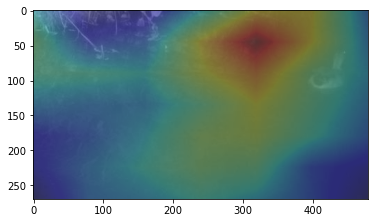

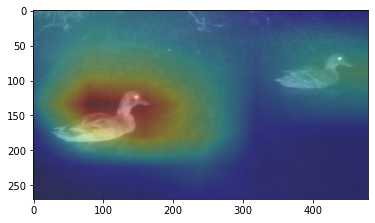

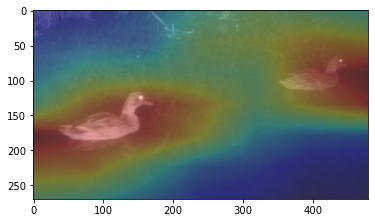

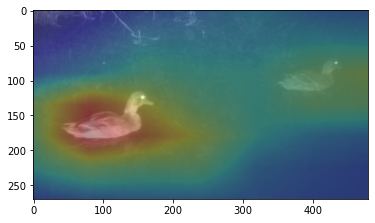

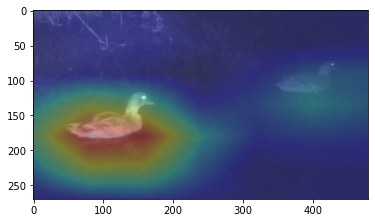

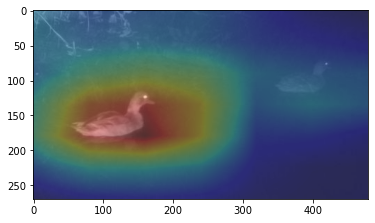

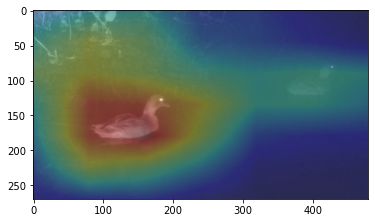

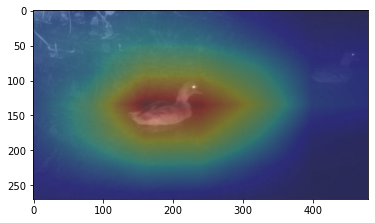

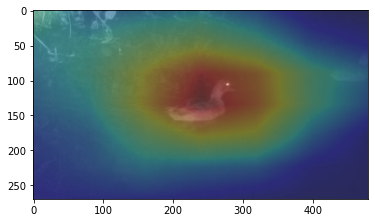

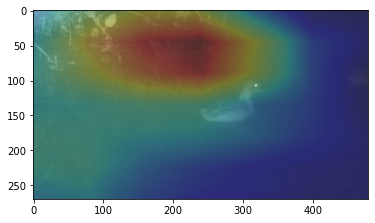

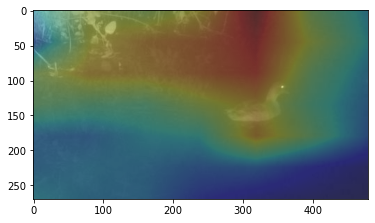

In [66]:
hoebeke.localize(sequence_grey.sequence, regions)